## Workplace Contact Data Set 

In [100]:
import pandas as pd
import numpy as np
import networkx as nx
import pickle

import matplotlib
matplotlib.use('Agg')
%matplotlib inline

/Users/jeremyd/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/jeremyd/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/jeremyd/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/jeremyd/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/jeremyd/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/jeremyd/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477

In [80]:
# Read in Contacts Data
contacts = pd.read_csv("../data/contacts.csv", header = None)

# Read in Department Data
department = pd.read_csv("../data/department.csv", header = None)

**Contact Data**
* number of rows = 9827
    * 9827 f-f interactions
* number of columns = 3
    * time
    * id of p1
    * id of p2

In [81]:
# dim stores [num rows, num cols]
c_dimension = contacts.shape
c_num_rows = c_dimension[0]
c_num_cols = c_dimension[1]
c_dimension

(9827, 3)

**Department Data**
* number of rows = 92
    * 92 employees
* number of columns = 2
    * id
    * department

In [82]:
d_dimension = department.shape
d_num_rows = d_dimension[0]
d_num_cols = d_dimension[1]
d_dimension

(92, 2)

**Cleaning the Data**  
* Need to modify time column to start from 0

In [83]:
# fixes time
def reduce_time(t):
    return t - 28800

In [84]:
contacts[0] = contacts[0].apply(reduce_time)

**Combine Data Sets - Contacts + Department**

* Use Department Data Frame to build a map from id to department

In [85]:
map_id_dep = {}
for i in range(d_num_rows):
    map_id_dep[department.iloc[i, 0]] = department.iloc[i, 1]

* Create a mapping from node id to floor 

In [86]:
map_id_floor = {}

# look through node ids
# if id is associated with a department on a floor, put id : 1 into the map
# else put id : 0 into the map
for id in map_id_dep.keys():
    dept = map_id_dep[id]
    if (dept == "DSE" or dept == "SRH"): 
        map_id_floor[id] = 0
    else:
        map_id_floor[id] = 1

* Define a function that adds departments to a df

In [87]:
def add_department(people, name, df, map):
    '''
    people: series of people's id
    name: string for name of the column
    df: dataframe
    map: map of id to department
    '''
    dep = []
    for ind in people:
        ind_dep = map.get(ind, -1)
        dep.append(ind_dep)
    
    df[name] = np.array(dep)

In [88]:
p1 = contacts[1] 
n1 = "d1"
add_department(p1, n1, contacts, map_id_dep)

contacts.head()

,0,1,2,d1
0,20,492,938,SRH
1,60,267,272,DSE
2,500,181,826,DSE
3,980,79,181,DSE
4,1200,150,196,SRH


In [89]:
p2 = contacts[2]
n2 = "d2"
add_department(p2, n2, contacts, map_id_dep)

contacts.head()

,0,1,2,d1,d2
0,20,492,938,SRH,DMCT
1,60,267,272,DSE,DSE
2,500,181,826,DSE,DISQ
3,980,79,181,DSE,DSE
4,1200,150,196,SRH,DSE


* Add Floors to the DataFrame

In [90]:
def add_floor(nodes, name, df, map):
    '''
    people: series of people's id
    name: string for name of the column
    df: dataframe
    map: map of id to department
    '''
    floor = []
    for n in nodes:
        n_floor = map.get(n, -1)
        floor.append(n_floor)
    
    df[name] = np.array(floor)

In [96]:
nodes1 = contacts[1]
name1 = "f1"
add_floor(nodes1, name1, contacts, map_id_floor)

contacts.head()

,0,1,2,d1,d2,f1
0,20,492,938,SRH,DMCT,0
1,60,267,272,DSE,DSE,0
2,500,181,826,DSE,DISQ,0
3,980,79,181,DSE,DSE,0
4,1200,150,196,SRH,DSE,0


In [98]:
nodes2 = contacts[2]
name2 = "f2"
add_floor(nodes2, name2, contacts, map_id_floor)

contacts.head()

,0,1,2,d1,d2,f1,f2
0,20,492,938,SRH,DMCT,0,1
1,60,267,272,DSE,DSE,0,0
2,500,181,826,DSE,DISQ,0,1
3,980,79,181,DSE,DSE,0,0
4,1200,150,196,SRH,DSE,0,0


### Contacts - Cleaned and Modified DF

In [99]:
contacts = contacts.rename(index = str, columns = {0 : "time", 1 : "n1", 2 : "n2"})
contacts.head()

,time,n1,n2,d1,d2,f1,f2
0,20,492,938,SRH,DMCT,0,1
1,60,267,272,DSE,DSE,0,0
2,500,181,826,DSE,DISQ,0,1
3,980,79,181,DSE,DSE,0,0
4,1200,150,196,SRH,DSE,0,0


In [106]:
filehandler = open("contacts_df.pickle", "wb")
pickle.dump(contacts, filehandler)

### graph_id - networkx graph (nodes = id)

In [49]:
graph_id = nx.from_pandas_dataframe(contacts, "p1", "p2", "time")


In [50]:
graph_id.nodes()

NodeView((492, 938, 267, 272, 181, 826, 79, 150, 196, 21, 205, 448, 765, 39, 253, 80, 123, 845, 118, 311, 95, 771, 153, 164, 179, 481, 122, 120, 819, 431, 778, 271, 601, 15, 56, 194, 786, 603, 496, 275, 222, 50, 172, 29, 223, 116, 285, 762, 63, 939, 335, 105, 113, 513, 119, 154, 494, 48, 209, 17, 66, 102, 134, 240, 242, 804, 511, 875, 184, 499, 268, 185, 533, 987, 210, 35, 131, 211, 751, 265, 784, 273, 662, 709, 101, 779, 132, 255, 213, 791, 743, 87))

In [51]:
graph_id.number_of_nodes()

92

In [52]:
graph_id.number_of_edges()

755

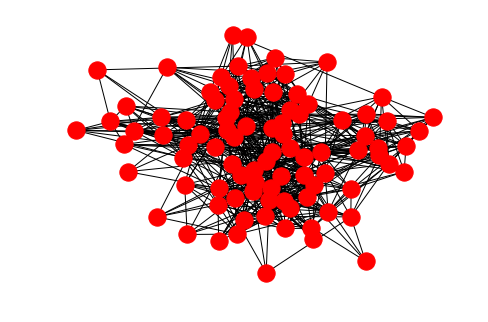

In [53]:
nx.draw(graph_id)

Edges in a Graph represent at least 1 face to face interaction between employees

In [54]:
list(graph_id.neighbors(35))

[210, 845, 826, 804, 273, 253, 265, 268, 185, 778, 743, 255]

Employee 35 interacted with 12 unique people

In [55]:
test = contacts[contacts["p1"] == 35]
test.p2.unique()

array([210, 845, 826, 804, 273, 253, 265, 268, 185, 778, 743, 255])

Employee 35 had a total interaction of 48 interactions

**Characteristics of the Network**

Network consists of 1 Giant Connected Component

In [56]:
nx.number_connected_components(graph_id)

1

Average Degree = 16.4

In [57]:
# Average Degree
graph_id_avg_degree = (2.0 * graph_id.number_of_edges())/graph_id.number_of_nodes()
graph_id_avg_degree

16.41304347826087

On Average, an employee interacts with approximately 18% of the other employees

In [58]:
graph_id_avg_degree / d_num_rows

0.17840264650283555

In [59]:
degrees = []
for node in department[0]:
    degrees.append(graph_id.degree(node))

degrees = pd.Series(degrees).value_counts()

d = degrees.index.values # get degrees
count = degrees.values # get counts

# Degree Distribution
plt.bar(d, count)

NameError: name 'plt' is not defined

**Average # of Interactions Per Person**
* avg = 213.63
    * while each person doesn't interact with a lot of other unique people, they interact a lot with the same people over and over again
* avg # of interactions per day = 19.42 (assuming 11 days)

In [ ]:
interactions = {}

p1_count = contacts["p1"].value_counts() # holds counts for p1
p2_count = contacts["p2"].value_counts() # holds counts for p2

for node in department[0]:
    interactions[node] = p1_count.get(node, 0) + p2_count.get(node, 0)

avg_interactions = np.mean(list(interactions.values())) # average # of interactions
avg_interactions

**Path Characteristics**

In [ ]:
nx.average_shortest_path_length(graph_id)

In [ ]:
nx.diameter(graph_id)

In [ ]:
nx.radius(graph_id)

**Analysis of Inter-department and Intra-department interactions**

In [ ]:
graph_dept = nx.from_pandas_dataframe(contacts, "p1 department", "p2 department", create_using =  nx.MultiGraph())

* 82% of contacts are within one's own department
* 18% of contacts are outside of one's own department

In [ ]:
sum(contacts["p1 department"] == contacts["p2 department"]) / c_num_rows

**Finding # of Interactions**

In [ ]:
# finds the number of contacts between 2 departments
def num_contacts(dept1, dept2, df, col1, col2):
    data = df[((df[col1] == dept1) & (df[col2] == dept2)) | ((df[col1] == dept2) & (df[col2] == dept1))]
    return data.shape[0]

* inter_dept_interactions is a dict mapping departments to an array storing the # of interactions between itself and other departments
    * array indices are recorded as follows
        * 0 - num of interactions w/ **DISQ**
        * 1 - num of interactions w/ **DSE**
        * 2 - num of interactions w/ **SFLE**
        * 3 - num of interactions w/ **DMCT**
        * 4 - num of interactions w/ **SRH**

In [ ]:
departments = department[1].unique() # unique departments
dept_interactions = {} # dict

for i in range(len(departments)):
    dept1 = departments[i]
    # print("dept1: {}".format(dept1))
    dept_contacts = []
    for j in range(len(departments)):
        dept2 = departments[j]
        # print("dept2: {}".format(dept2))
        dept_contacts.append(num_contacts(dept1, dept2, contacts, "p1 department", "p2 department"))
        # print(dept_contacts)
    dept_interactions[dept1] = dept_contacts
    
dept_interactions

In [ ]:
df_dept_counts = pd.DataFrame(dept_interactions, index = ["DISQ", "DSE", "SFLE", "DMCT", "SRH"])
df_dept_counts = df_dept_counts.T

df_dept_counts

In [ ]:
dept_ratios = {}
for key in dept_interactions.keys():
    dept_ratios[key] = dept_interactions[key] / np.sum(dept_interactions[key])

dept_ratios

**Table of Departmental Interactions**
* rows = departments
* columns = departments that department interacts with  

Note: Discrepancy between SRH - DISQ vs DISQ - SRH comes from dividing by sum

In [ ]:
df_dept = pd.DataFrame(dept_ratios, index = ["DISQ", "DSE", "SFLE", "DMCT", "SRH"])
df_dept = df_dept.T

df_dept

**Observations**
* DISQ - 57% internal
* DMCT - 58% internal
* DSE - 71% internal
* SFLE - 18% internal
* SRH - 89% internal

Note: Interactions don't seem to be split by floors. Interactions are heavily influenced by the role of the department. Confirms finding that research groups form a subnetwork of connectedness

** Additional Explorations **